<a href="https://colab.research.google.com/github/lucaskydelima/Optimization-with-Python-Pyomo/blob/main/S4Example3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pyomo

In [60]:
import os
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import pandas as pd

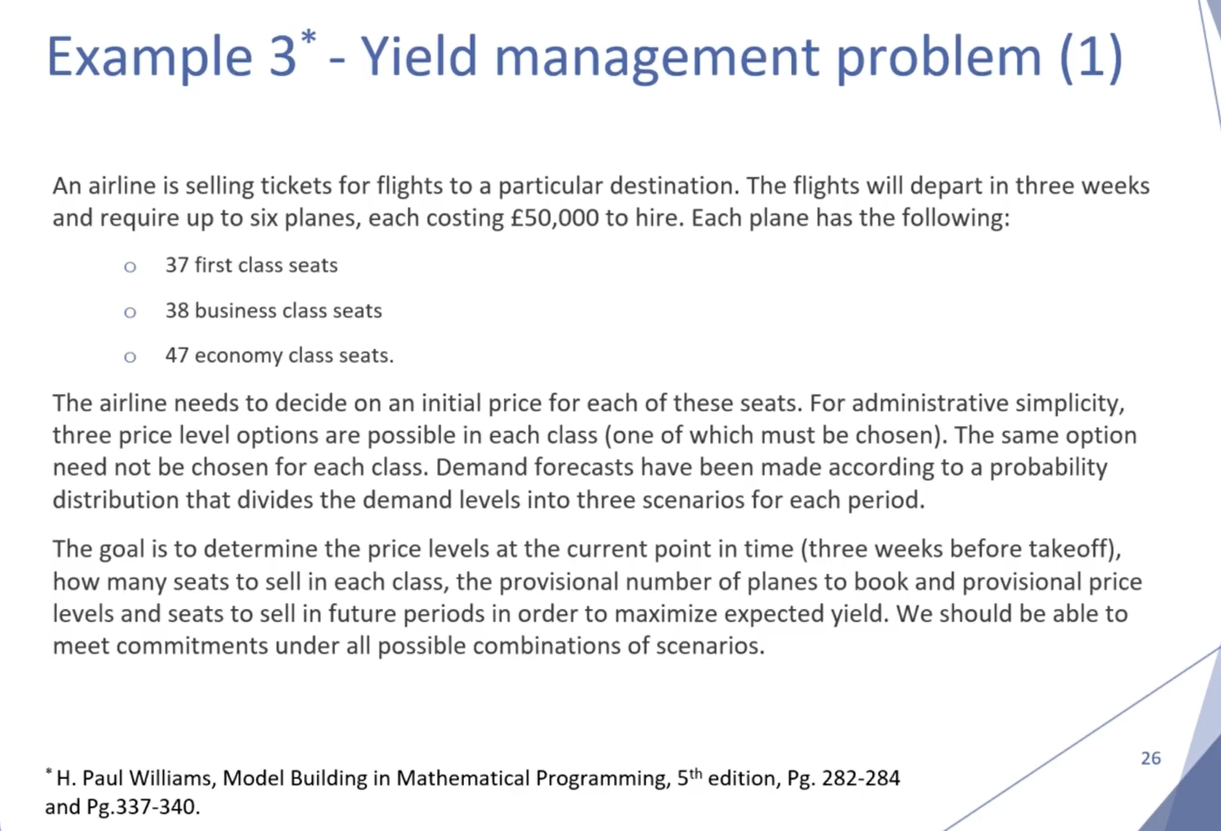

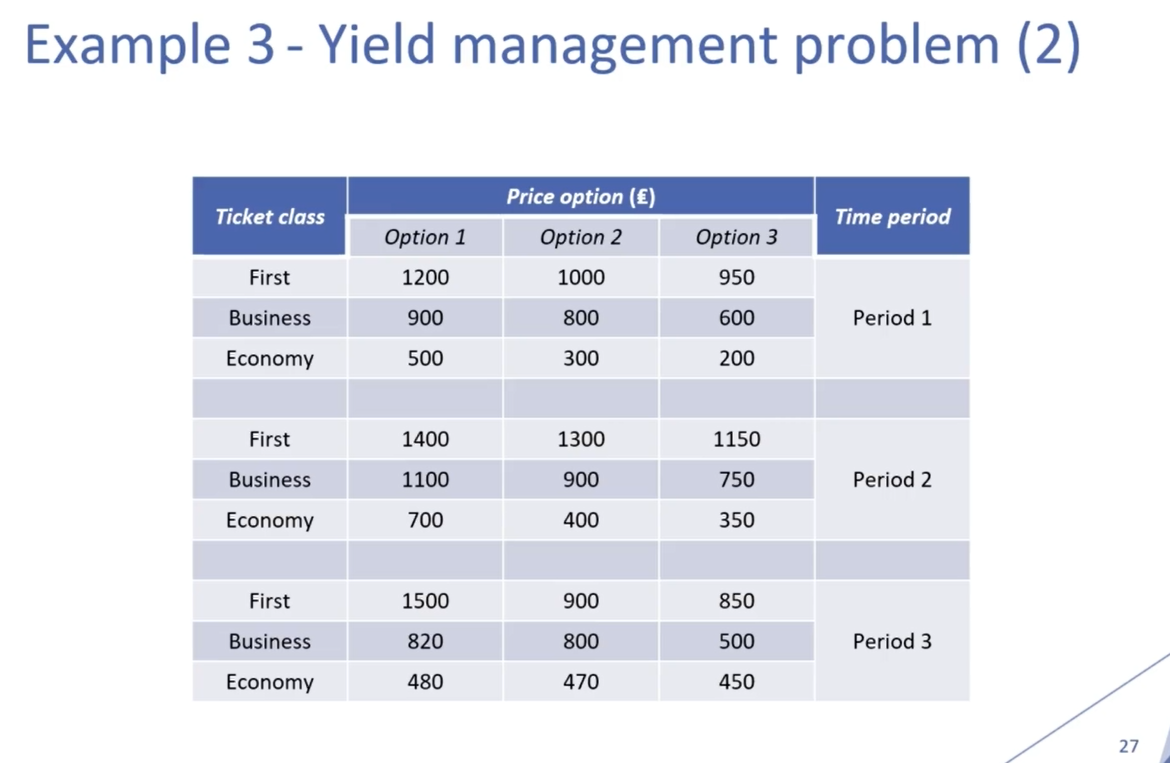

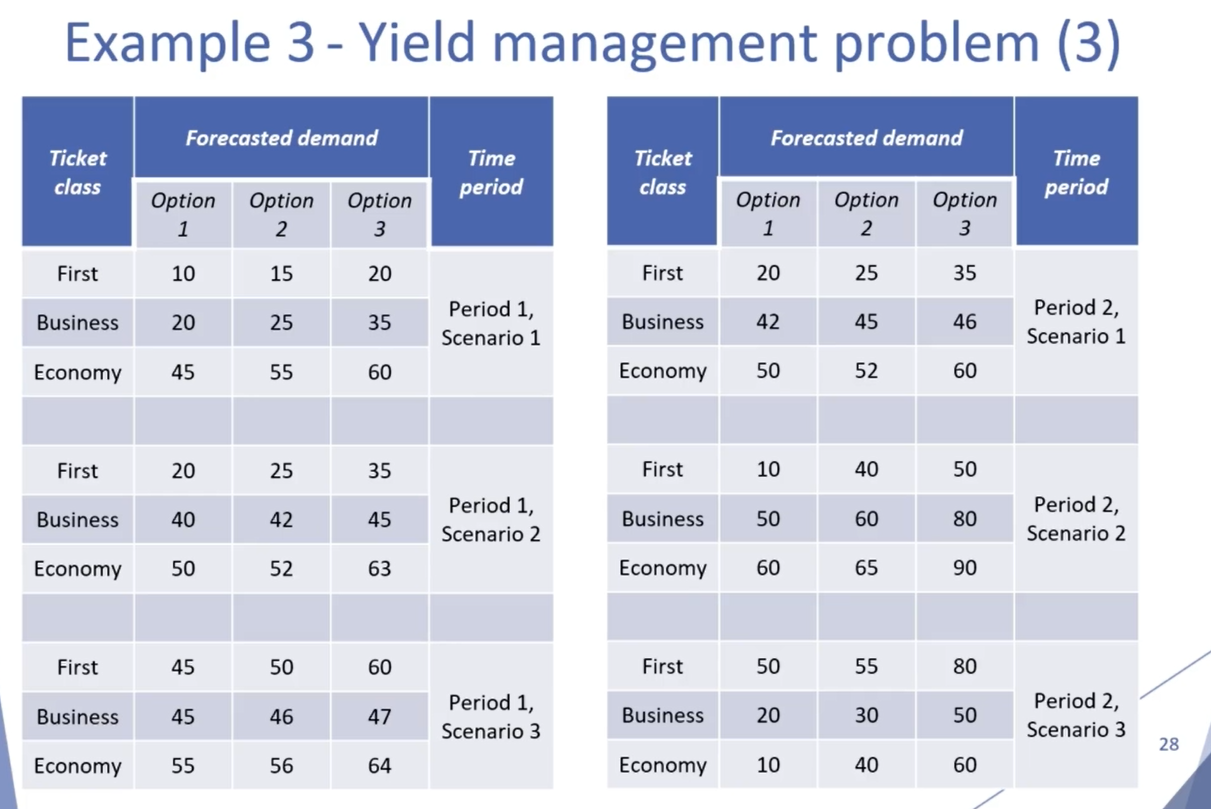

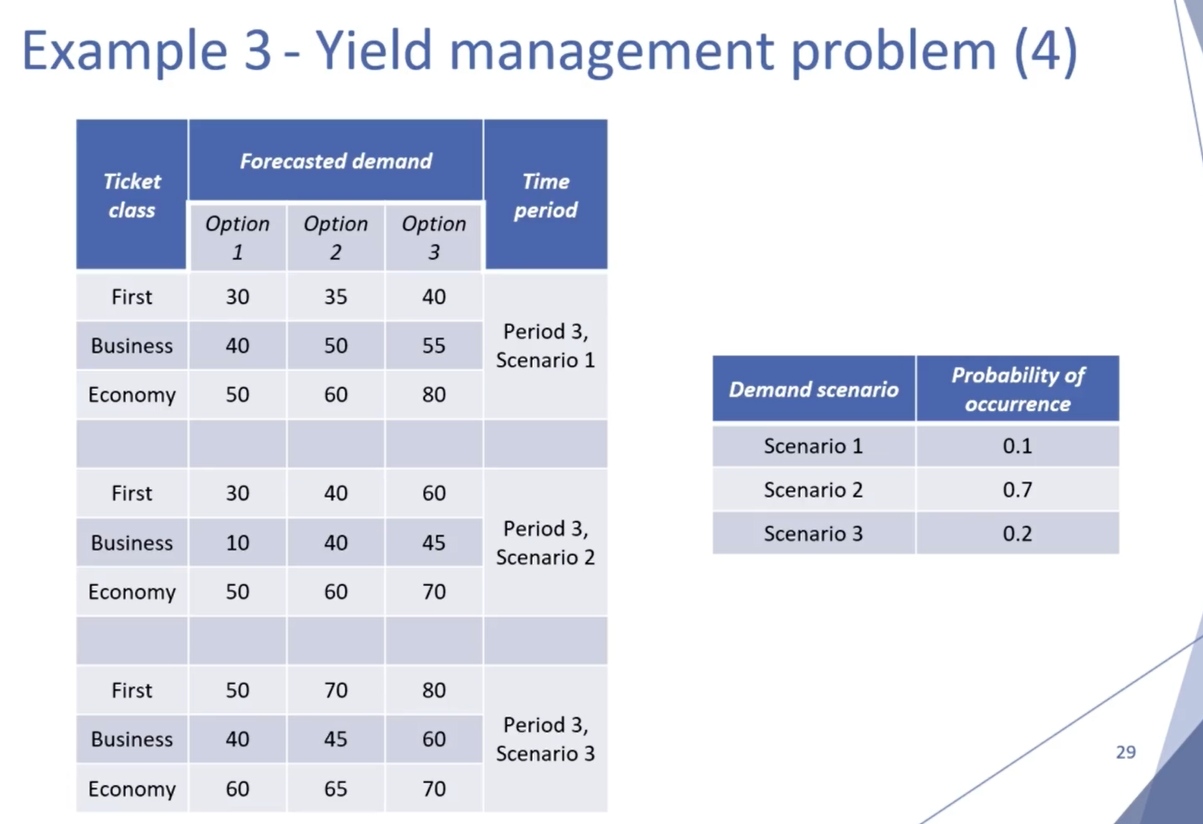

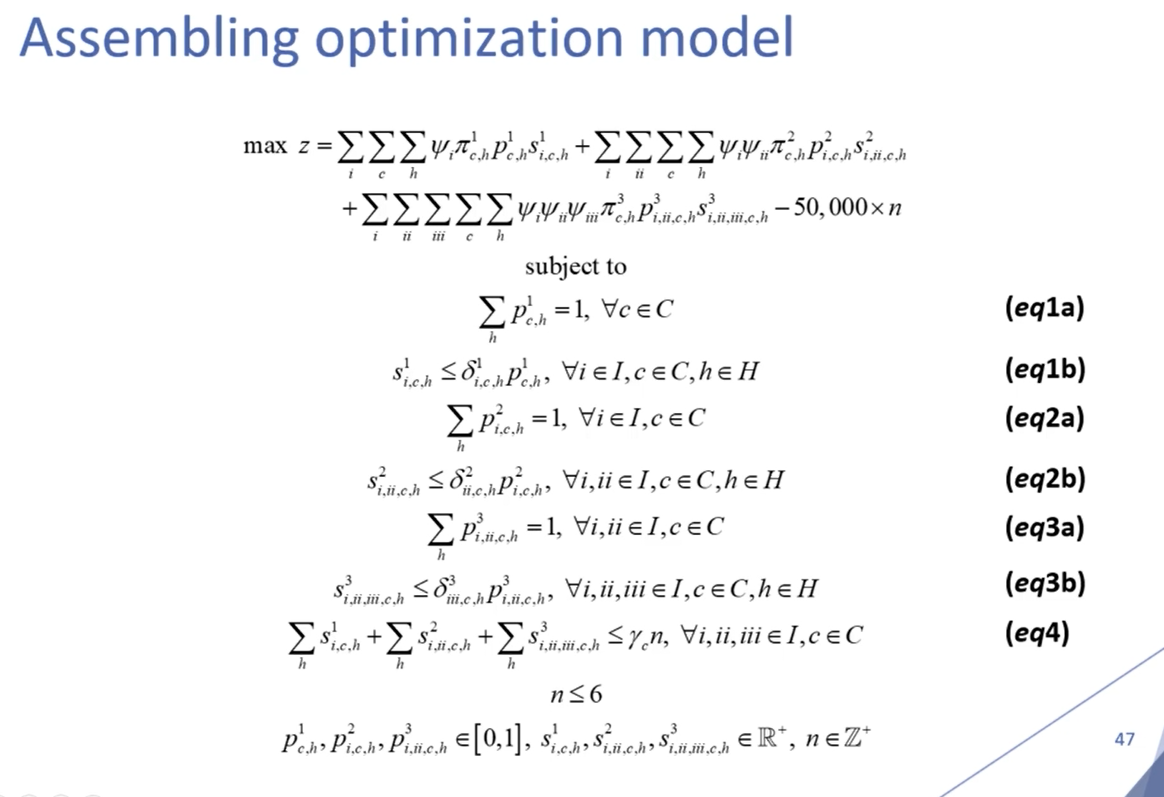

In [88]:
# Defining the model
model = pyo.ConcreteModel()

# Sets
model.c = pyo.Set(initialize=['First', 'Business','Economy'])
model.h = pyo.Set(initialize=['Option1', 'Option2', 'Option3'])
model.i = pyo.Set(initialize=['Scenario1', 'Scenario2', 'Scenario3'])

model.ii = pyo.Set(initialize=model.i)
model.iii = pyo.Set(initialize=model.i)

# Params
model.psi = pyo.Param(model.i, initialize={'Scenario1':0.1, 'Scenario2':0.7, 'Scenario3':0.2})

delta1 = pd.read_excel('Pyomo_MINLP_example_3_input_data.xls', sheet_name='Sheet1', header=1, index_col=[0,1], usecols='A:E', nrows=9).fillna('')

delta2 = pd.read_excel('Pyomo_MINLP_example_3_input_data.xls', sheet_name='Sheet1', header=1, index_col=[0,1], usecols='G:k', nrows=9).fillna('')
delta2 = delta2.rename(columns={'Option1.1':'Option1', 'Option2.1':'Option2', 'Option3.1':'Option3'})

delta3 = pd.read_excel('Pyomo_MINLP_example_3_input_data.xls', sheet_name='Sheet1', header=1, index_col=[0,1], usecols='M:Q', nrows=9).fillna('')
delta3 = delta3.rename(columns={'Option1.2':'Option1', 'Option2.2':'Option2', 'Option3.2':'Option3'})

pi1 = pd.read_excel('Pyomo_MINLP_example_3_input_data.xls', sheet_name='Sheet1', header=1, index_col=[0], usecols='A:D', skiprows=12).fillna('')

pi2 = pd.read_excel('Pyomo_MINLP_example_3_input_data.xls', sheet_name='Sheet1', header=1, index_col=[0], usecols='G:J', skiprows=12).fillna('')
pi2 = pi2.rename(columns={'Option1.1':'Option1', 'Option2.1':'Option2', 'Option3.1':'Option3'})

pi3 = pd.read_excel('Pyomo_MINLP_example_3_input_data.xls', sheet_name='Sheet1', header=1, index_col=[0], usecols='M:P', skiprows=12).fillna('')
pi3 = pi3.rename(columns={'Option1.2':'Option1', 'Option2.2':'Option2', 'Option3.2':'Option3'})

model.gamma = pyo.Param(model.c, initialize={'First':37, 'Business':38, 'Economy':47})

# Decision Variables
model.p1 = pyo.Var(model.c, model.h, domain=pyo.Binary, doc = 'Whether price option h is chosen for ticket class c in week 1')
model.p2 = pyo.Var(model.i, model.c, model.h, domain=pyo.Binary, doc = 'Whether price option h is chosen for ticket class c in week 2, with demand scenario i occuring in week 1')
model.p3 = pyo.Var(model.i, model.ii, model.c, model.h, domain=pyo.Binary, doc = 'Whether price option h is chosen for ticket class c in week 3, with demand scenario i and ii occuring in week 1 and 2, respectively')

model.s1 = pyo.Var(model.i, model.c, model.h, domain=pyo.NonNegativeReals, doc = 'Number of tickets sold of type c with price option h in week 1 with demand scenario i')
model.s2 = pyo.Var(model.i, model.ii, model.c, model.h, domain=pyo.NonNegativeReals, doc = 'Number of tickets sold of type c with price option h in week 2 with demand scenario i in week 1 and ii in week 2')
model.s3 = pyo.Var(model.i, model.ii, model.iii, model.c, model.h, domain=pyo.NonNegativeReals, doc = 'Number of tickets sold of type c with price option h in week 3 with demand scenarios i, ii, iii in weeks 1, 2 and 3, respectively')

model.n = pyo.Var(domain=pyo.NonNegativeIntegers, bounds=(0,6))

# Constraints
def rule1a(model, c):
  return sum(model.p1[c,h] for h in model.h) == 1
model.const1 = pyo.Constraint(model.c, rule=rule1a, doc = 'Only one price option can be chosen in week 1')

def rule1b(model,i,c,h):
  return model.s1[i,c,h] <= delta1[h][i][c]*model.p1[c,h]
model.const2 = pyo.Constraint(model.i, model.c, model.h, rule=rule1b, doc = 'Sales must not exceed demand in week 1')

def rule2a(model,i,c):
  return sum(model.p2[i,c,h] for h in model.h) == 1
model.const3 = pyo.Constraint(model.i, model.c, rule=rule2a, doc = 'Only one price option can be chosen in week 2')

def rule2b(model,i,ii,c,h):
  return model.s2[i,ii,c,h] <= delta2[h][ii][c]*model.p2[i,c,h]
model.const4 =pyo.Constraint(model.i, model.ii, model.c, model.h, rule=rule2b, doc = 'Sales must not exceed demand in week 2')

def rule3a(model,i,ii,c):
  return sum(model.p3[i,ii,c,h] for h in model.h) == 1
model.const5 = pyo.Constraint(model.i, model.ii, model.c, rule=rule3a, doc = 'Only one price option can be chosen in week 3')

def rule3b(model,i,ii,iii,c,h):
  return model.s3[i,ii,iii,c,h] <= delta3[h][iii][c]*model.p3[i,ii,c,h]
model.const6 = pyo.Constraint(model.i, model.ii, model.iii, model.c, model.h, rule=rule3b, doc = 'Sales must not exceed demand in week 3')

def rule4(model,i,ii,iii,c):
  return (sum(model.s1[i,c,h] for h in model.h) + sum(model.s2[i,ii,c,h] for h in model.h) + sum(model.s3[i,ii,iii,c,h] for h in model.h)) <= model.gamma[c]*model.n
model.const7 = pyo.Constraint(model.i, model.ii, model.iii, model.c, rule=rule4, doc = 'Seat capacity must be abided by')

# Objective Function
def Objective_rule(model):
  term1 = sum(sum(sum(model.psi[i]*pi1[h][c]*model.p1[c,h]*model.s1[i,c,h] for i in model.i) for c in model.c) for h in model.h)
  term2 = sum(sum(sum(sum(model.psi[i]*model.psi[ii]*pi2[h][c]*model.p2[i,c,h]*model.s2[i,ii,c,h] for i in model.i) for ii in model.ii) for c in model.c) for h in model.h)
  term3 = sum(sum(sum(sum(sum(model.psi[i]*model.psi[ii]*model.psi[iii]*pi3[h][c]*model.p3[i,ii,c,h]*model.s3[i,ii,iii,c,h] for i in model.i) for ii in model.ii) for iii in model.iii) for c in model.c) for h in model.h)
  term4 = 50000*model.n
  return term1 + term2 + term3 - term4

model.obj = pyo.Objective(rule=Objective_rule, sense=pyo.maximize)

# Solve
os.environ['NEOS_EMAIL'] = 'lucaskydelima@gmail.com'
results = pyo.SolverManagerFactory('neos').solve(model, opt='minlp')

results.write()
print('\nRESULTS')
print('Total revenue: ', model.obj())
print('Number of planes to book =', model.n())

print('\nWeek 1 provisional prices: ')
for c in model.c:
  for h in model.h:
    if model.p1[c,h].value != 0:
      print(c,'class tickets with price',h,'=',pi1[h][c],'pounds')

print('\nWeek 2 provisional prices: ')
for i in model.i:
  for c in model.c:
    for h in model.h:
      if model.p2[i,c,h].value != 0:
        print('(Week1:',i,'),', '=>', c,'class tickets with price',h,'=',pi2[h][c],'pounds')

print('\nWeek 3 provisional prices: ')
for i in model.i:
  for ii in model.ii:
    for c in model.c:
      for h in model.h:
        if model.p3[i,ii,c,h].value != 0:
          print('(Week1:',i,'),','(Week2:',ii,') =>', c,'class tickets with price',h,'=',pi3[h][c],'pounds')

print('\nNumber of tickets booked in week 1: ')
for i in model.i:
  for c in model.c:
    for h in model.h:
      print('(Week1:',i,'),',c,h,' => Number of tickets =', model.s1[i,c,h].value)

print('\nNumber of tickets booked in week 2: ')
for i in model.i:
  for ii in model.ii:
    for c in model.c:
      for h in model.h:
        print('(Week1:',i,'),','(Week2:',ii,'),',c,h,' => Number of tickets =', model.s2[i,ii,c,h].value)

print('\nNumber of tickets booked in week 3: ')
for i in model.i:
  for ii in model.ii:
    for iii in model.iii:
      for c in model.c:
        for h in model.h:
          print('(Week1:',i,'),','(Week2:',ii,'),','(Week3:',iii,'),',c,h,' => Number of tickets =', model.s3[i,ii,iii,c,h].value)


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 471
  Number of variables: 469
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: MINLP-B&B (20100607)\x3a Optimal solution found; 3 subproblems, objective = 126736.86000000022; Evals\x3a obj = 209, constr = 209, grad = 80, Hes = 81
  Termination condition: optimal
  Id: 0
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Soluti